# Machine Learning I - Practical I

Name: {YOUR NAME}

Course: {NAME OF YOUR PROGRAM}

This notebook provides you with the assignments and the overall code structure you need to complete the assignment. Each exercise indicates the total number of points allocated. There are also questions that you need to answer in text form. Please use full sentences and reasonably correct spelling/grammar.

Regarding submission & grading:

- Solutions can be uploaded to ILIAS until the indicated deadline. Please upload a copy of this notebook and a PDF version of it after you ran it.

- Please hand in your own solution. You are encouraged to discuss your code with classmates and help each other, but after that, please sit down for yourself and write your own code. 

- We will grade not only based on the outputs, but also look at the code. So please use comments make us understand what you intended to do :)

- For plots you create yourself, all axes must be labeled. 

- DO NOT IN ANY CASE change the function interfaces.

- If you are not familiar with python, then this may be of help. This is a colab notebook which is part of the Convolutional Neural Networks for Visual Recognition course (CS231n) in Stanford. It goes through some of the basic elements of Python and Numpy. You can run it directly in the browser without having Python installed:
    
    https://colab.research.google.com/github/cs231n/cs231n.github.io/blob/master/python-colab.ipynb#scrollTo=U1PvreR9L9eW  
    

- If you are not familiar with python, but used MATLAB before, check out this reference pages listing what you want to use as python equivalent of a certain MATLAB command:

    https://docs.scipy.org/doc/numpy/user/numpy-for-matlab-users.html
    
    http://www.eas.uccs.edu/~mwickert/ece5650/notes/NumPy2MATLAB.pdf
    
    http://mathesaurus.sourceforge.net/matlab-python-xref.pdf
    
    or, if you prefer to read a longer article, try: 
    
    https://realpython.com/matlab-vs-python/#learning-about-pythons-mathematical-libraries
    
    

In [36]:
%matplotlib notebook

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
from scipy import stats
import copy
import pylab
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score

## The  dataset

The dataset consists of over 20.000 materials and lists their physical features. From these features, we want to learn how to predict the critical temperature, i.e. the temperature we need to cool the material to so it becomes superconductive. First load and familiarize yourself with the data set a bit.

In [37]:
data=pd.read_csv('superconduct_train.csv')
print(data.shape)

(21263, 82)


In [38]:
data.head()

number_of_elements  mean_atomic_mass  wtd_mean_atomic_mass  \
0                   4         88.944468             57.862692   
1                   5         92.729214             58.518416   
2                   4         88.944468             57.885242   
3                   4         88.944468             57.873967   
4                   4         88.944468             57.840143   

   gmean_atomic_mass  wtd_gmean_atomic_mass  entropy_atomic_mass  \
0          66.361592              36.116612             1.181795   
1          73.132787              36.396602             1.449309   
2          66.361592              36.122509             1.181795   
3          66.361592              36.119560             1.181795   
4          66.361592              36.110716             1.181795   

   wtd_entropy_atomic_mass  range_atomic_mass  wtd_range_atomic_mass  \
0                 1.062396          122.90607              31.794921   
1                 1.057755          122.90607              36.161939   
2                 0.975980          122.90607              35.741099   
3                 1.022291          122.90607              33.768010   
4                 1.129224          122.90607              27.848743   

   std_atomic_mass  ...  wtd_mean_Valence  gmean_Valence  wtd_gmean_Valence  \
0        51.968828  ...          2.257143       2.213364           2.219783   
1        47.094633  ...          2.257143       1.888175           2.210679   
2        51.968828  ...          2.271429       2.213364           2.232679   
3        51.968828  ...          2.264286       2.213364           2.226222   
4        51.968828  ...          2.242857       2.213364           2.206963   

   entropy_Valence  wtd_entropy_Valence  range_Valence  wtd_range_Valence  \
0         1.368922             1.066221              1           1.085714   
1         1.557113             1.047221              2           1.128571   
2         1.368922             1.029175              1           1.114286   
3         1.368922             1.048834              1           1.100000   
4         1.368922             1.096052              1           1.057143   

   std_Valence  wtd_std_Valence  critical_temp  
0     0.433013         0.437059           29.0  
1     0.632456         0.468606           26.0  
2     0.433013         0.444697           19.0  
3     0.433013         0.440952           22.0  
4     0.433013         0.428809           23.0  

[5 rows x 82 columns]

Because the dataset is rather large, we prepare a small subset of the data as training set, and another subset as test set. To make the computations reproducible, we set the random seed.

In [39]:
target_clm = 'critical_temp' # the critical temperature is our target variable
n_trainset = 200 # size of the training set
n_testset = 500 #size of the test set

In [40]:
# set random seed to make sure every test set is the same
np.random.seed(seed=1)

idx = np.arange(data.shape[0])
idx_shuffled = np.random.permutation(idx) # shuffle indices to split into training and test set

test_idx = idx_shuffled[:n_testset]
train_idx = idx_shuffled[n_testset:n_testset+n_trainset]
train_full_idx = idx_shuffled[n_testset:]

X_test = data.loc[test_idx, data.columns != target_clm].values
y_test = data.loc[test_idx, data.columns == target_clm].values
print('Test set shapes (X and y)', X_test.shape, y_test.shape)

X_train = data.loc[train_idx, data.columns != target_clm].values
y_train = data.loc[train_idx, data.columns == target_clm].values
print('Small training set shapes (X and y):',X_train.shape, y_train.shape)

X_train_full = data.loc[train_full_idx, data.columns != target_clm].values
y_train_full = data.loc[train_full_idx, data.columns == target_clm].values
print('Full training set shapes (X and y):',X_train_full.shape, y_train_full.shape)

Test set shapes (X and y) (500, 81) (500, 1)
Small training set shapes (X and y): (200, 81) (200, 1)
Full training set shapes (X and y): (20763, 81) (20763, 1)


## Task 1: Plot the dataset [5 pts]

To explore the dataset, use `X_train_full` and `y_train_full` for two descriptive plots:

* **Histogram** of the target variable. Use `plt.hist`.

* **Scatterplots** relating the target variable to one of the feature values. For this you will need 81 scatterplots. Arrange them in one big figure with 9x9 subplots. Use `plt.scatter`. You may need to adjust the marker size and the alpha blending value. 

<IPython.core.display.Javascript object>


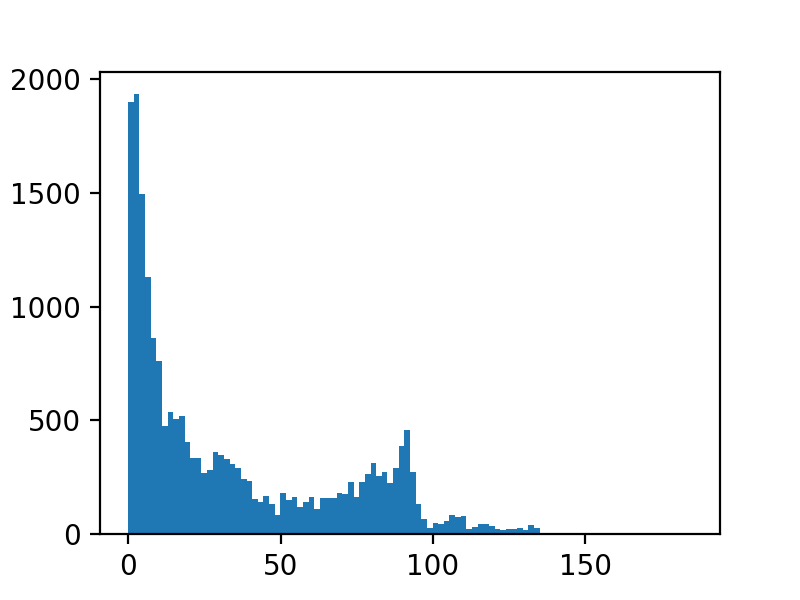

In [41]:
# Histogram of the target variable

# HIDE THIS CELL

plt.figure(figsize=(4,3))
plt.hist(y_train_full,bins=100);

<IPython.core.display.Javascript object>


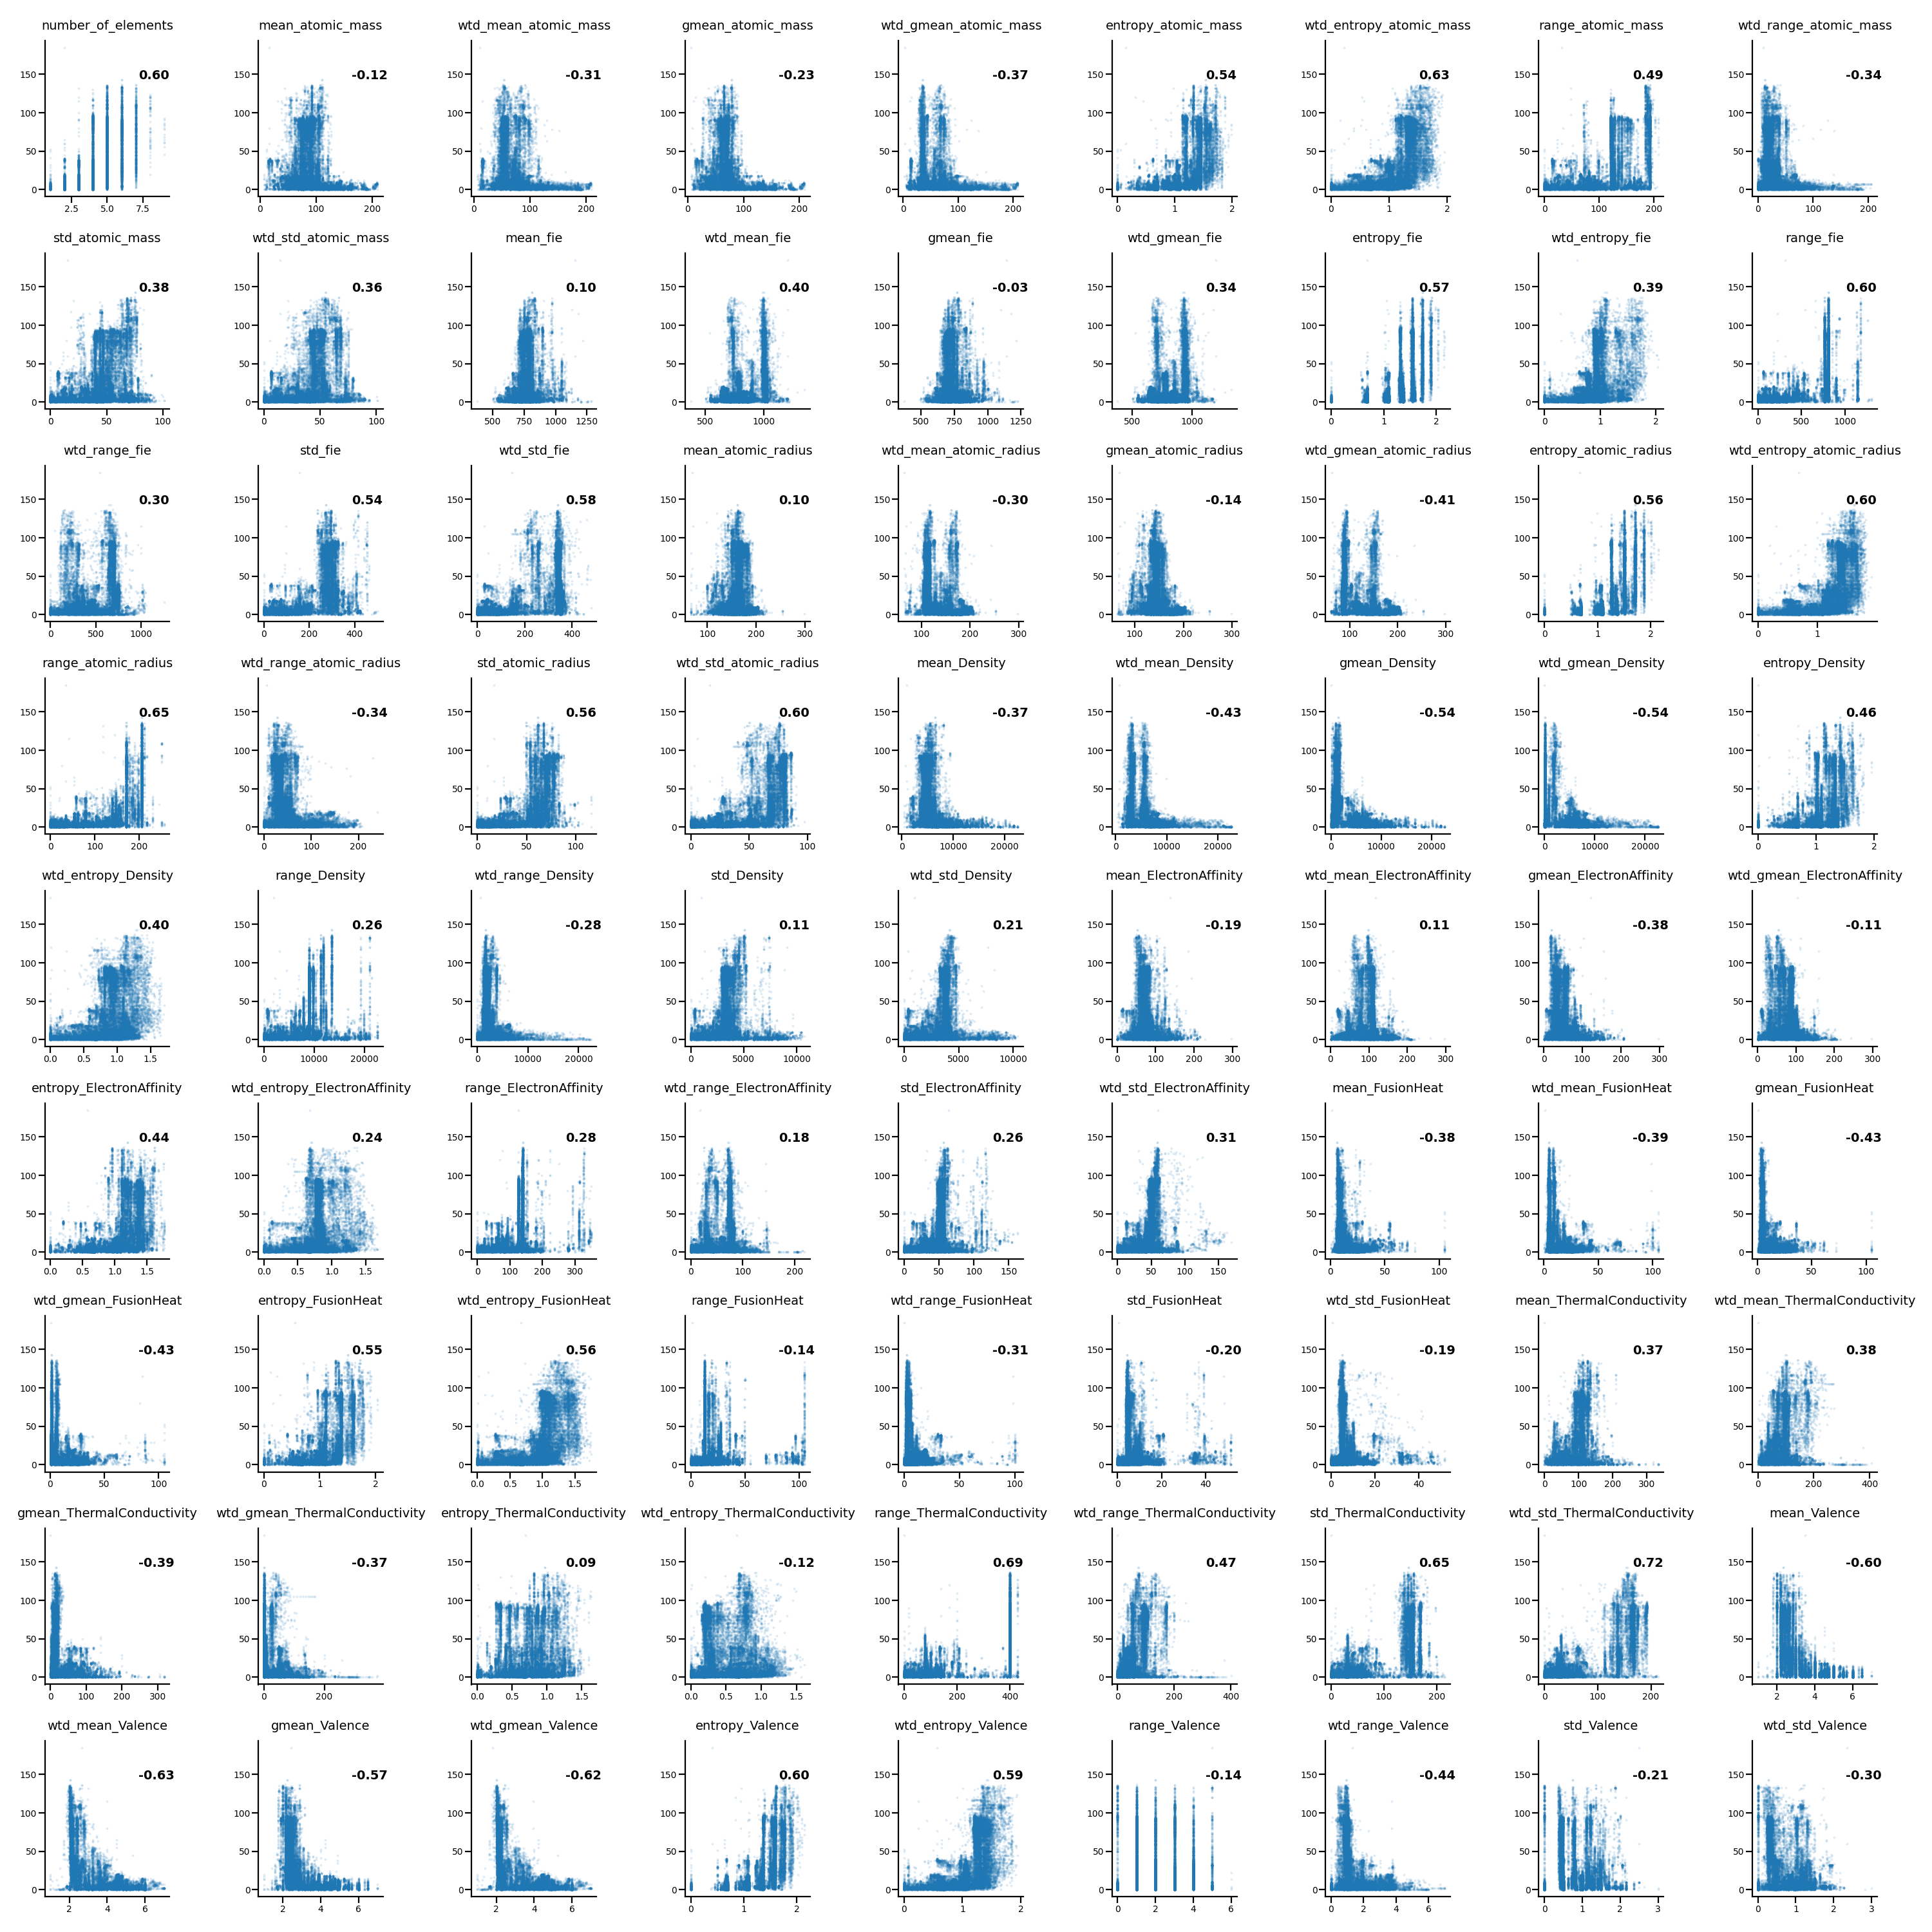

In [54]:
# Scatter plots of the target variable vs. features

# HIDE THIS CELL

fig,ax = plt.subplots(9,9,figsize=(15,15))
plt.subplots_adjust(wspace=0.3,hspace=0.3)
ax = ax.flatten()
for i in range(81):

    ax[i].scatter(X_train_full[:,i], y_train_full, s=.1, alpha=.2)
    ax[i].set_title(data.columns[i],fontsize='7')
    ax[i].tick_params(labelsize='5',pad=1)
    
    corr = np.corrcoef(X_train_full[:,i], y_train_full.T)[0,1]
    ax[i].text(0.75, 0.75,'%.2f'%(corr), fontsize=7, fontweight='bold', transform=ax[i].transAxes)
    sns.despine()
plt.tight_layout()

Which material properties may be useful for predicting superconductivity? What other observations can you make?

- Maybe the first is not bad
- no single feature can individually predict the target
- some are correlated to the target 
- many seem non-linearly related to the target
- some clearly don't work at all (bimodal etc)
- Integer (dicsrete) vs real (continuous) feature

In [8]:
def plot_regression_results(y_test,y_pred,weights):
    '''Produces three plots to analyze the results of linear regression:
        -True vs predicted
        -Raw residual histogram
        -Weight histogram
        
    Inputs:
        y_test: (n_observations,) numpy array with true values
        y_pred: (n_observations,) numpy array with predicted values
        weights: (n_weights) numpy array with regression weights'''
    
    print('MSE: ', mean_squared_error(y_test,y_pred))
    print('r^2: ', r2_score(y_test,y_pred))
    
    fig,ax = plt.subplots(1,3,figsize=(9,3))
    #predicted vs true
    ax[0].scatter(y_test,y_pred)
    ax[0].set_title('True vs. Predicted')
    ax[0].set_xlabel('True %s' % (target_clm))
    ax[0].set_ylabel('Predicted %s' % (target_clm))

    #residuals
    error = np.squeeze(np.array(y_test)) - np.squeeze(np.array(y_pred))
    ax[1].hist(np.array(error),bins=30)
    ax[1].set_title('Raw residuals')
    ax[1].set_xlabel('(true-predicted)')

    #weight histogram
    ax[2].hist(weights,bins=30)
    ax[2].set_title('weight histogram')

    plt.tight_layout()

As an example, we here show you how to use this function with random data. 

MSE:  2640.432578444892
r^2:  -1.108062856115481


<IPython.core.display.Javascript object>


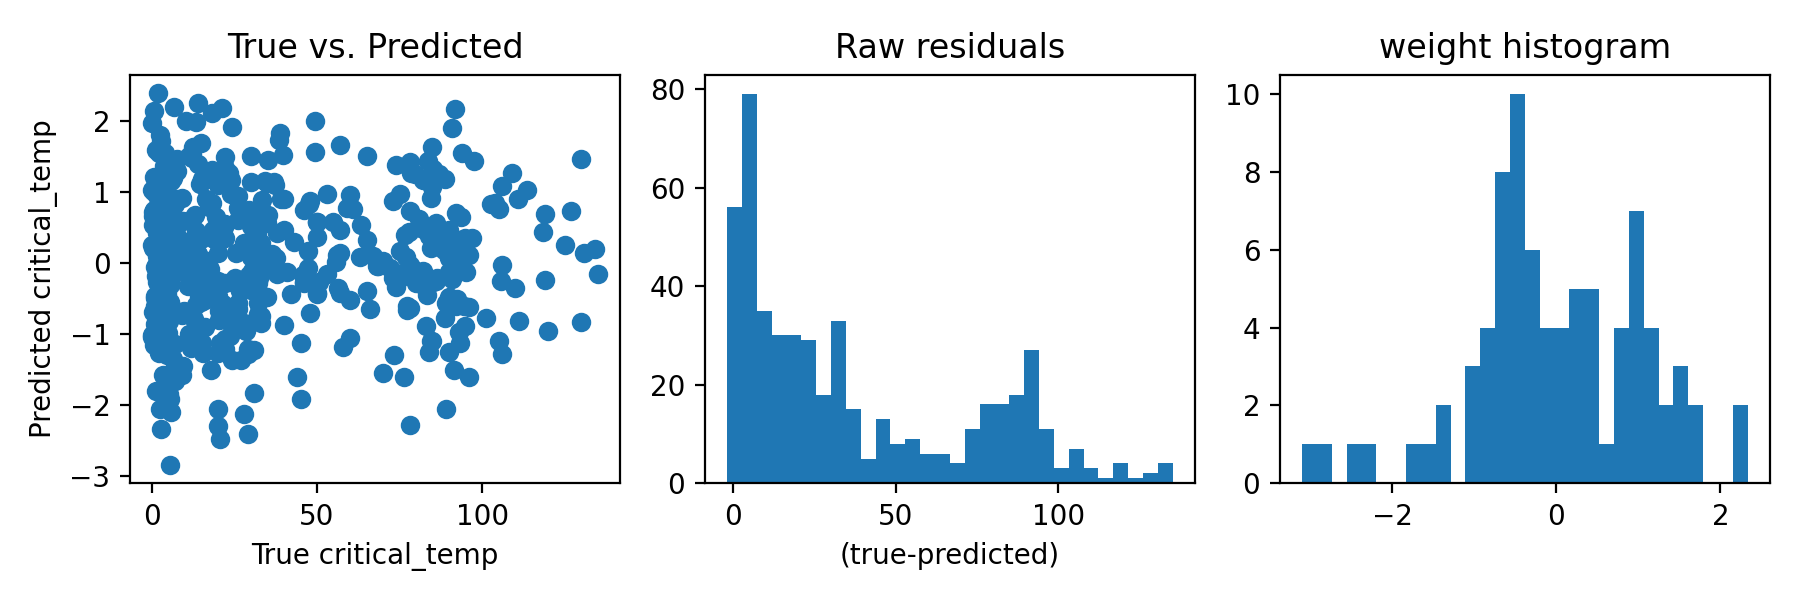

In [9]:
# weights is a vector of length 82: the first value is the intercept (beta0), then 81 coefficients
weights = np.random.randn(82)

# Model predictions on the test set
y_pred_test = np.random.randn(y_test.size)

plot_regression_results(y_test, y_pred_test, weights)

Implement OLS linear regression yourself. Use `X_train` and `y_train` for estimating the weights and compute the MSE and $r^2$ from `X_test`. When you call our plotting function with the regession result, you should get mean squared error of 599.7.

## Task 2:  Implement your own OLS estimator [10 pts]

We want to use linear regression to predict the critical temperature. Implement the ordinary least squares estimator without regularization 'by hand':

$w = (X^TX)^{-1}X^Ty$

To make life a bit easier, we provide a function that can be used to plot regression results. In addition it computes the mean squared error and the squared correlation between the true and predicted values. 

In [10]:
def OLS_regression(X_test, X_train, y_train):
    '''Computes OLS weights for linear regression without regularization on the training set and 
       returns weights and testset predictions.
    
       Inputs:
         X_test: (n_observations, 81), numpy array with predictor values of the test set 
         X_train: (n_observations, 81), numpy array with predictor values of the training set
         y_train: (n_observations,) numpy array with true target values for the training set
         
       Outputs:
         weights: The weight vector for the regerssion model including the offset
         y_pred: The predictions on the TEST set
         
       Note:
         Both the training and the test set need to be appended manually by a columns of 1s to add
         an offset term to the linear regression model.        
    
    '''
    
    # ---------------- REMOVE -------------------------
    
    X = np.concatenate((np.ones((n_trainset,1)),X_train),axis=1)
    XX = np.dot(X.T,X)
    XX_inv = np.linalg.inv(XX)
    XX_inv_X = np.dot(XX_inv,X.T)
    weights = np.dot(XX_inv_X,y_train)
    
    Xt = np.concatenate((np.ones((n_testset,1)),X_test),axis=1)
    y_pred = np.matmul(Xt,weights)
    
    # ---------------- END REMOVE -------------------------
    
    return weights, y_pred


MSE:  599.739762538461
r^2:  0.521181064396856


<IPython.core.display.Javascript object>


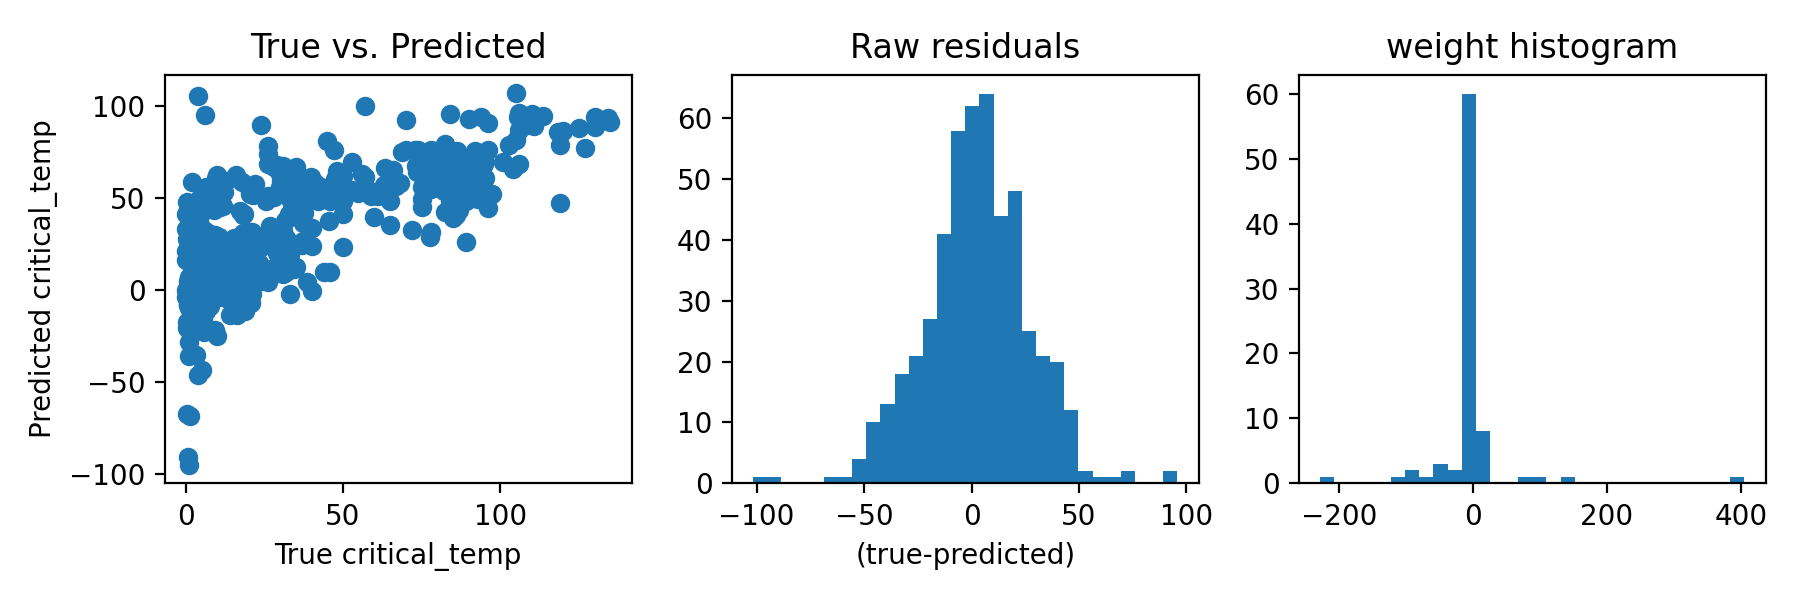

In [11]:
# Plots of the results

# HIDE THIS CELL
weights, y_pred = OLS_regression(X_test, X_train, y_train)
plot_regression_results(y_test, y_pred, weights)

In [12]:
weights[:10]

array([[ 23.35700908],
       [-17.55255417],
       [  3.25121613],
       [ -3.14782541],
       [ -2.90331004],
       [  2.94256622],
       [-56.68932703],
       [ 83.16909629],
       [  0.1873939 ],
       [  0.18636591]])

What do you observe? Is the linear regression model good?

- below-zero predictions dont make (physical) sense / are not meaningful
- there is some correlation between pred. / true values
- many small weights, few large weights, scope for regularization 
- residuals symmetric

Simple linear model is not very good

## Task 3: Compare your implementation to sklearn [5 pts]

Now, familarize yourself with the sklearn library. In the section on linear models:

https://scikit-learn.org/stable/modules/classes.html#module-sklearn.linear_model

you will find `sklearn.linear_model.LinearRegression`, the `sklearn` implementation of the OLS estimator. Use this sklearn class to implement OLS linear regression. Again obtain estimates of the weights on `X_train` and `y_train` and compute the MSE and $r^2$ on `X_test`.


In [13]:
def sklearn_regression(X_test, X_train, y_train):
    '''Computes OLS weights for linear regression without regularization using the sklearn library on the training set and 
       returns weights and testset predictions.
    
       Inputs:
         X_test: (n_observations, 81), numpy array with predictor values of the test set 
         X_train: (n_observations, 81), numpy array with predictor values of the training set
         y_train: (n_observations,) numpy array with true target values for the training set
         
       Outputs:
         weights: The weight vector for the regerssion model including the offset
         y_pred: The predictions on the TEST set
          
         
       Note:
         The sklearn library automatically takes care of adding a column for the offset.     
    
    '''
    
    # ---------------- REMOVE -------------------------
    
    simple_regression = linear_model.LinearRegression()
    
    # Train the model using the training set
    simple_regression.fit(X_train, y_train)
    
    # Make predictions using the test set
    y_pred = simple_regression.predict(X_test)
    
    # Weights
    weights = np.squeeze(simple_regression.coef_)
    
    # ---------------- END REMOVE -------------------------
    
    return weights, y_pred

MSE:  599.7397626158698
r^2:  0.5211810643350543


<IPython.core.display.Javascript object>


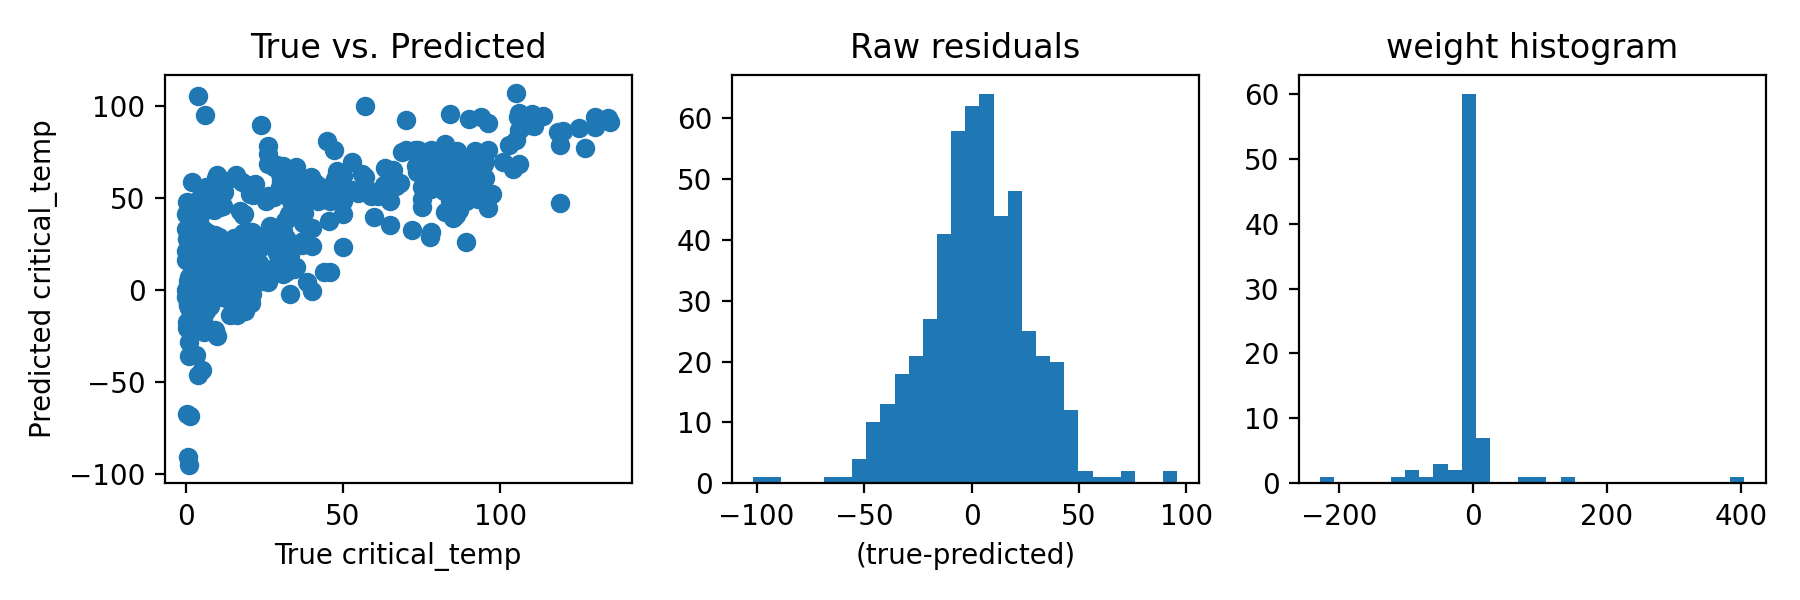

In [14]:
weights, y_pred = sklearn_regression(X_test, X_train, y_train)
plot_regression_results(y_test, y_pred, weights)

In [15]:
weights[:10]

array([-17.55255416,   3.25121613,  -3.14782541,  -2.90331004,
         2.94256622, -56.68932704,  83.16909628,   0.18739391,
         0.18636591,  -1.48690329])

If you implemented everything correctly, the MSE is again 599.74.

Fit the model using the larger training set, `X_train_full` and `y_train_full`, and again evaluate on `X_test`.

MSE:  329.8607010411315
r^2:  0.7366465263178332


<IPython.core.display.Javascript object>


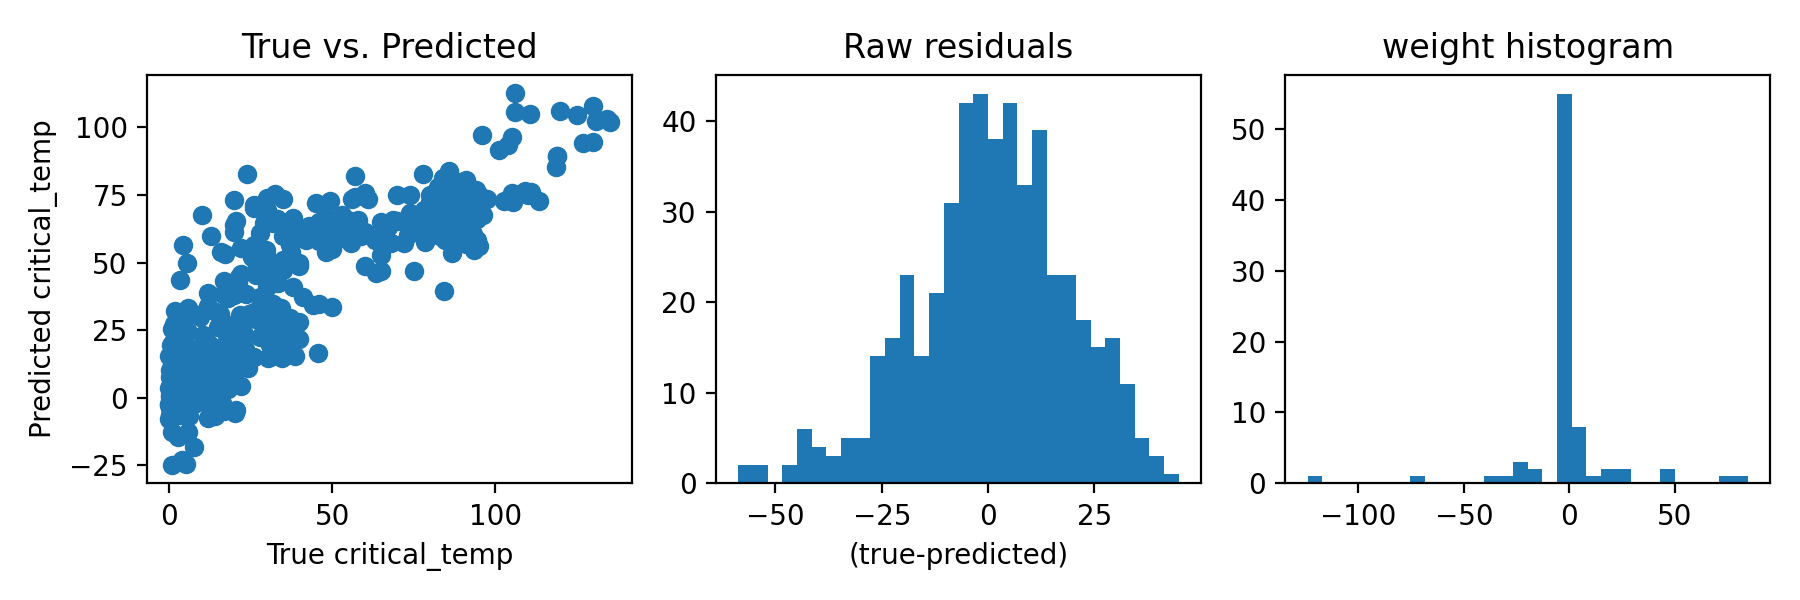

In [16]:
weights, y_pred = sklearn_regression(X_test, X_train_full, y_train_full)
plot_regression_results(y_test, y_pred, weights)

In [18]:
weights[:10]

array([-3.63687475e+00,  8.49757837e-01, -9.09902898e-01, -5.08957736e-01,
        6.48329374e-01, -3.64646937e+01,  4.37067047e+00,  2.11731478e-01,
        2.84403133e-02, -5.52091697e-01])

 How does test set performance change? What else changes?

- Still below zero predictions, however the extent is smaller 
- MSE halves, +20% var expl.
- smaller weights, we have more data but the same number of features 
- smaller residuals (smaller spread!), fewer extreme errors
- clearer that it works better than the model with fewer training samples

## Task 4: Regularization with ridge regression [15 pts]

We will now explore how a penalty term on the weights can improve the prediction quality for finite data sets. Implement the analytical solution of ridge regression 

$w = (X^TX + \alpha I_D)^{-1}X^Ty$


as a function that can take different values of $\alpha$, the regularization strength, as an input. In the lecture, this parameter was called $\lambda$, but this is a reserved keyword in Python.

In [19]:
def ridge_regression(X_test, X_train, y_train, alpha):
    '''Computes OLS weights for regularized linear regression with regularization strength alpha 
       on the training set and returns weights and testset predictions.
    
       Inputs:
         X_test: (n_observations, 81), numpy array with predictor values of the test set 
         X_train: (n_observations, 81), numpy array with predictor values of the training set
         y_train: (n_observations,) numpy array with true target values for the training set
         alpha: scalar, regularization strength
         
       Outputs:
         weights: The weight vector for the regerssion model including the offset
         y_pred: The predictions on the TEST set
          
       Note:
         Both the training and the test set need to be appended manually by a columns of 1s to add
         an offset term to the linear regression model.       
    
    '''

    # ---------------- REMOVE -------------------------
    
    # Compute MLE solution
    X = np.concatenate((np.ones((X_train.shape[0],1)),X_train),axis=1)
    XX = np.dot(X.T,X)
    XX_ridge=alpha*np.eye(XX.shape[0]) + XX
    XX_inv_ridge = np.linalg.inv(XX_ridge)
    XX_inv_ridge = np.dot(XX_inv_ridge,X.T)
    weights = np.dot(XX_inv_ridge,y_train)
    
    # Make predictions using the test set
    x_test_tmp = np.concatenate((np.ones((X_test.shape[0],1)),X_test),axis=1)
    y_pred = np.matmul(x_test_tmp,weights)
    
    # ---------------- END REMOVE -------------------------
        
    return weights, y_pred

Now test a range of log-spaced $\alpha$s (~10-20), which cover several orders of magnitude, e.g. from 10^-7 to 10^7. 

* For each $\alpha$, you will get one model with one set of weights. 
* For each model, compute the error on the test set. 

Store both the errors and weights of all models for later use. You can use the function `mean_squared_error` from sklearn (imported above) to compute the MSE.


In [20]:
alphas = np.logspace(-7,7,100)

# ---------------- REMOVE -------------------------

weights = np.zeros((alphas.size, 82))
MSEs=[]

for i in range(len(alphas)):
    w, y_pred = ridge_regression(X_test, X_train, y_train, alphas[i])
    weights[i,:] = w.squeeze()
    MSEs.append(mean_squared_error(y_pred,y_test))
    
    
# ---------------- END REMOVE ----------------------


Make a single plot that shows for each coefficient how it changes with $\alpha$, i.e. one line per coefficient. Also think about which scale is appropriate for your $\alpha$-axis. You can set this using `plt.xscale(...)`.

<IPython.core.display.Javascript object>


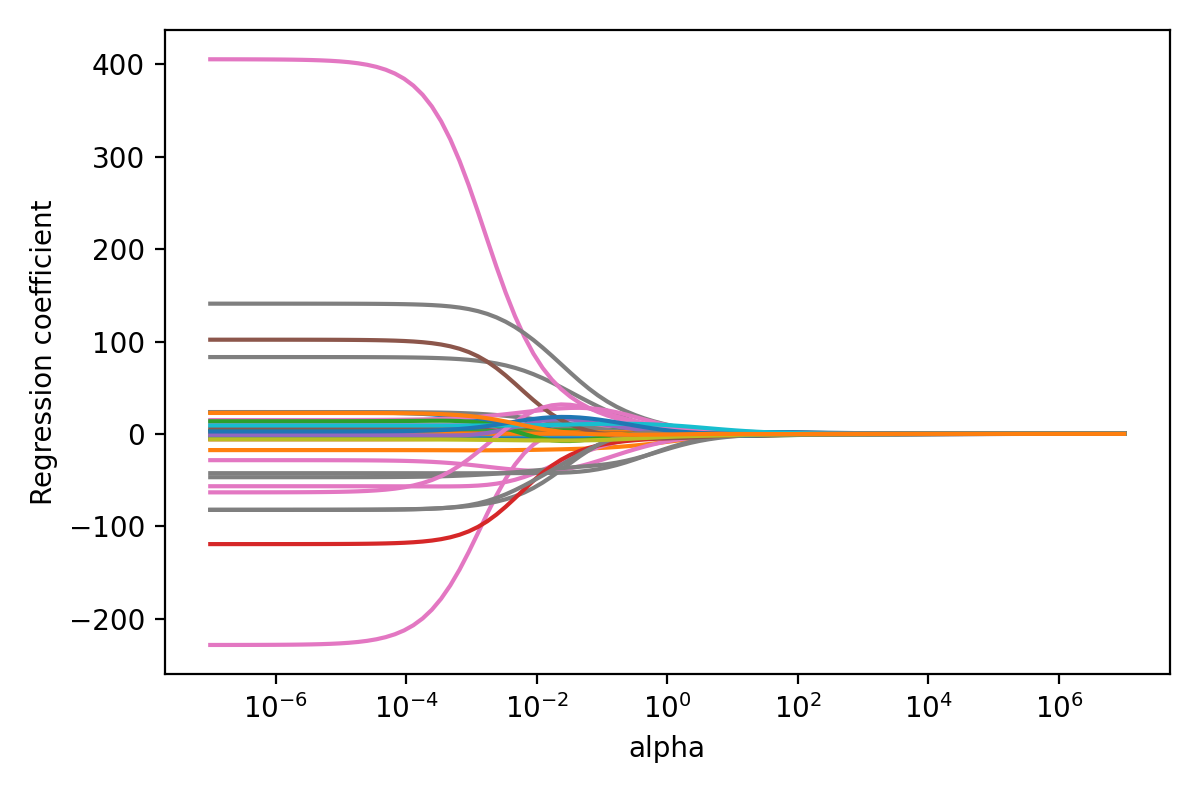

In [21]:
# ---------------- REMOVE -------------------------
    
plt.figure(figsize=(6,4))
plt.plot(alphas, weights);   
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('Regression coefficient')
plt.tight_layout()
    
# ---------------- END REMOVE ----------------------  


Why are the values of the weights largest on the left? Do they all change monotonically? 

- penalty is smallest on the left
- no, because making one weight small can allow another to be bigger again
- the sign flip is a bit weird (maybe one of the U-shaped features?)
- missing normalization could be an issue (because small-scaled features have to be scaled up by the weights, this is peanalized, so small features might drop out at some point, then other features take over)

Plot how the performance (i.e. the error) changes as a function of $\alpha$. As a sanity check, the MSE value for very small $\alpha$s should be close to the test-set MSE of the unregularized solution, i.e. 599.

<IPython.core.display.Javascript object>


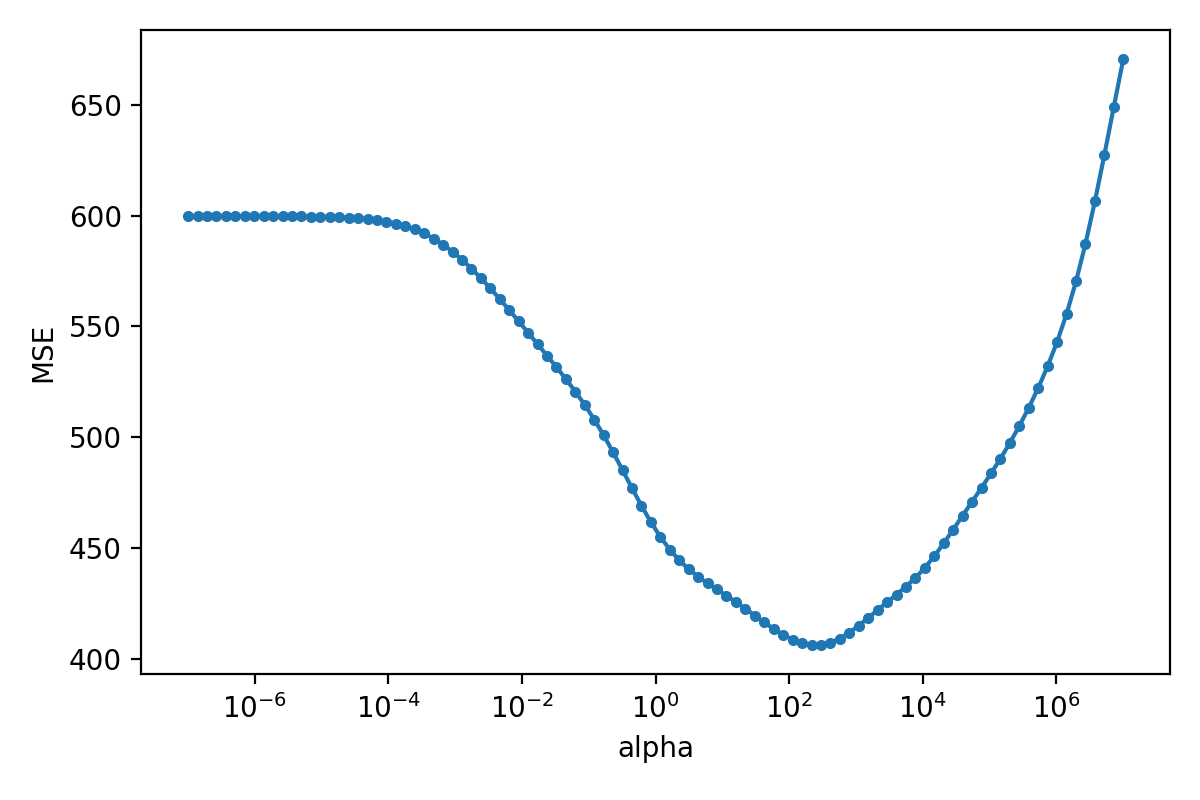

In [22]:
# ---------------- REMOVE -------------------------

plt.figure(figsize=(6,4))
plt.plot(alphas, MSEs, '.-')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.tight_layout()

# ---------------- REMOVE END ----------------------


In [24]:
print('optimal alpha: ',alphas[np.argmin(MSEs)])
print('MSE at optimal alpha: ',np.min(MSEs))

optimal alpha:  215.44346900318777
MSE at optimal alpha:  406.2638214328142


Which value of $\alpha$ gives the minimum MSE? Is it better than the unregularized model? Why should the curve reach ~600 on the left?

- best alpha in the range of 200-300
- yes is better (MSE ca 400 vs 600 before)
- to the left => unregularized, so we should get the error from before

Now implement the same model using sklearn. Use the `linear_model.Ridge` object to do so.


In [25]:
def ridge_regression_sklearn(X_test, X_train, y_train,alpha):
    '''Computes OLS weights for regularized linear regression with regularization strength alpha using the sklearn
       library on the training set and returns weights and testset predictions.
    
       Inputs:
         X_test: (n_observations, 81), numpy array with predictor values of the test set 
         X_train: (n_observations, 81), numpy array with predictor values of the training set
         y_train: (n_observations,) numpy array with true target values for the training set
         alpha: scalar, regularization strength
         
       Outputs:
         weights: The weight vector for the regerssion model including the offset
         y_pred: The predictions on the TEST set
          
       Note:
         The sklearn library automatically takes care of adding a column for the offset.     
   
    
    '''
    
    # ---------------- REMOVE -------------------------

    regr = linear_model.Ridge(alpha)

    # Train the model using the training set
    regr.fit(X_train, y_train)
    
    # Make predictions using the test set
    y_pred = regr.predict(X_test)
    
    weights = np.squeeze(regr.coef_)
    
    # ---------------- END REMOVE -------------------------
            
    return weights, y_pred

This time, only plot how the performance changes as a function of $\alpha$. 

<IPython.core.display.Javascript object>


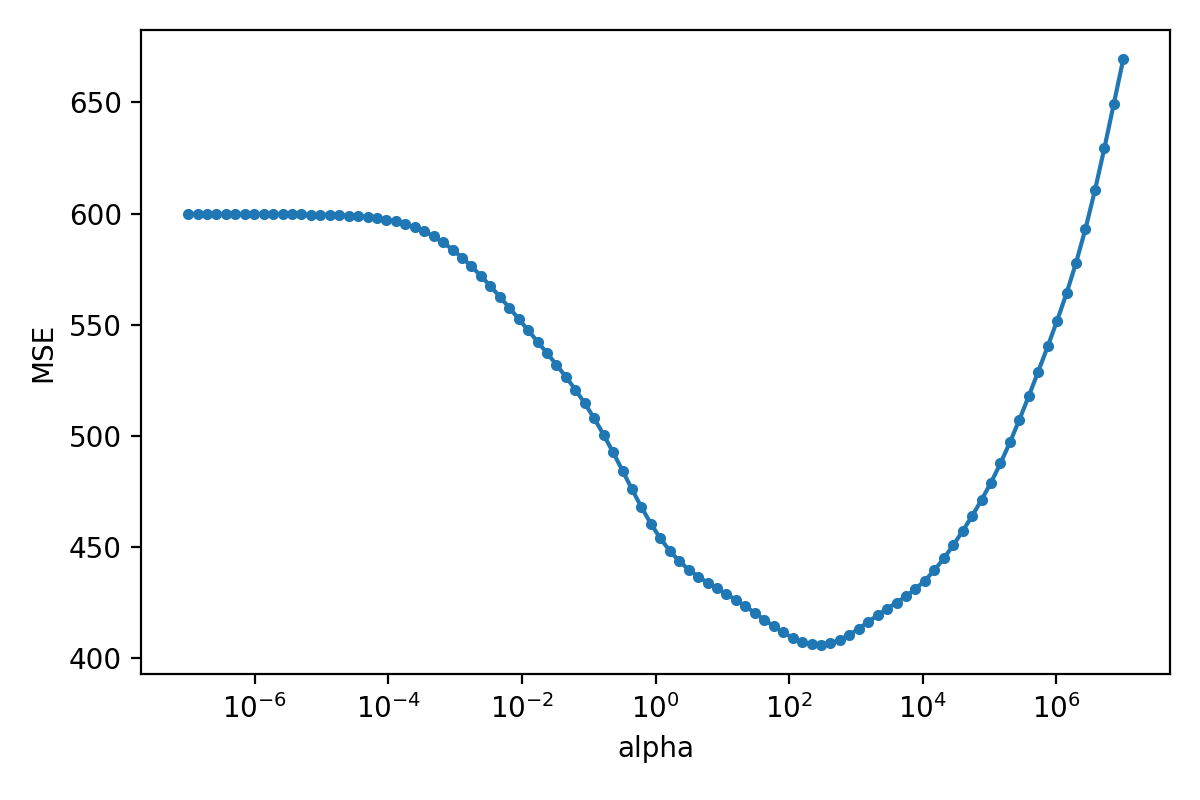

In [26]:
 # ---------------- REMOVE -------------------------

alphas = np.logspace(-7,7,100)
MSEs=[]

for i in range(len(alphas)):
    weights, y_pred = ridge_regression_sklearn(X_test, X_train, y_train, alphas[i])
    MSEs.append(mean_squared_error(y_pred,y_test))
    
plt.figure(figsize=(6,4))
plt.plot(alphas, MSEs, '.-')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.tight_layout()

 # ---------------- REMOVE END -------------------------

In [27]:
print('optimal alpha: ',alphas[np.argmin(MSEs)])
print('MSE at optimal alpha: ',np.min(MSEs))

optimal alpha:  298.3647240283334
MSE at optimal alpha:  405.67783542104223


Note: Don't worry if the curve is not exactly identical to the one you got above. The loss function we wrote down in the lecture  has $\alpha$ defined a bit differently compared to sklearn. However, qualitatively it should look the same.

## Task 5: Cross-validation [15 pts]

Until now, we always estimated the error on the test set directly. However, we typically do not want to tune hyperparameters of our inference algorithms like $\alpha$ on the test set, as this may lead to overfitting. Therefore, we tune them on the training set using cross-validation. As discussed in the lecture, the training data is here split in `n_folds`-ways, where each of the folds serves as a held-out dataset in turn and the model is always trained on the remaining data. Implement a function that performs cross-validation for the ridge regression parameter $\alpha$. You can reuse functions written above.

In [28]:
# change CV to guarantee equally sized folds

def ridgeCV(X, y, n_folds, alphas):
    '''Runs a n_fold-crossvalidation over the ridge regression parameter alpha. 
       The function should train the linear regression model for each fold on all values of alpha.
    
      Inputs: 
        X: (n_obs, n_features) numpy array - predictor
        y: (n_obs,) numpy array - target
        n_folds: integer - number of CV folds
        alphas: (n_parameters,) - regularization strength parameters to CV over
        
      Outputs:
        cv_results_mse: (n_folds, len(alphas)) numpy array, MSE for each cross-validation fold 
        
      Note: 
        Fix the seed for reproducibility.
        
        '''    
    
    cv_results_mse = np.zeros((n_folds, len(alphas)))
    np.random.seed(seed=2)

    
    # --------------------------- REMOVE FROM HERE ---------------------

    # Generate CV folds. Here we will randomly assign each training set sample
    # to one of the folds. Therefore we shuffle the indices and split them in.
    # batches.
    
    reorder_ids = np.random.permutation(len(y))
    for i in range(n_folds):
        testobs_this_fold = reorder_ids[int(len(y)/n_folds*i):int(len(y)/n_folds*(i+1))]
        trainobs_this_fold = reorder_ids[np.in1d(reorder_ids,testobs_this_fold,invert=True)]

        X_test_this_fold = X[testobs_this_fold,:]
        y_test_this_fold = y[testobs_this_fold,:]
        X_train_this_fold = X[trainobs_this_fold,:]
        y_train_this_fold = y[trainobs_this_fold,:]


        for ai,alpha in enumerate(alphas):
            weights, y_pred = ridge_regression(X_test_this_fold, X_train_this_fold, y_train_this_fold,alpha)
            cv_results_mse[i,ai]=mean_squared_error(y_pred,y_test_this_fold)
            
    # --------------------------- END REMOVE ---------------------
            
    return cv_results_mse    

Now we run 10-fold cross-validation using the training data of a range of $\alpha$s.

In [29]:
alphas = np.logspace(-7,7,100)
mse_cv = ridgeCV(X_train, y_train, n_folds=10, alphas=alphas)

We plot the MSE trace for each fold separately:

<IPython.core.display.Javascript object>


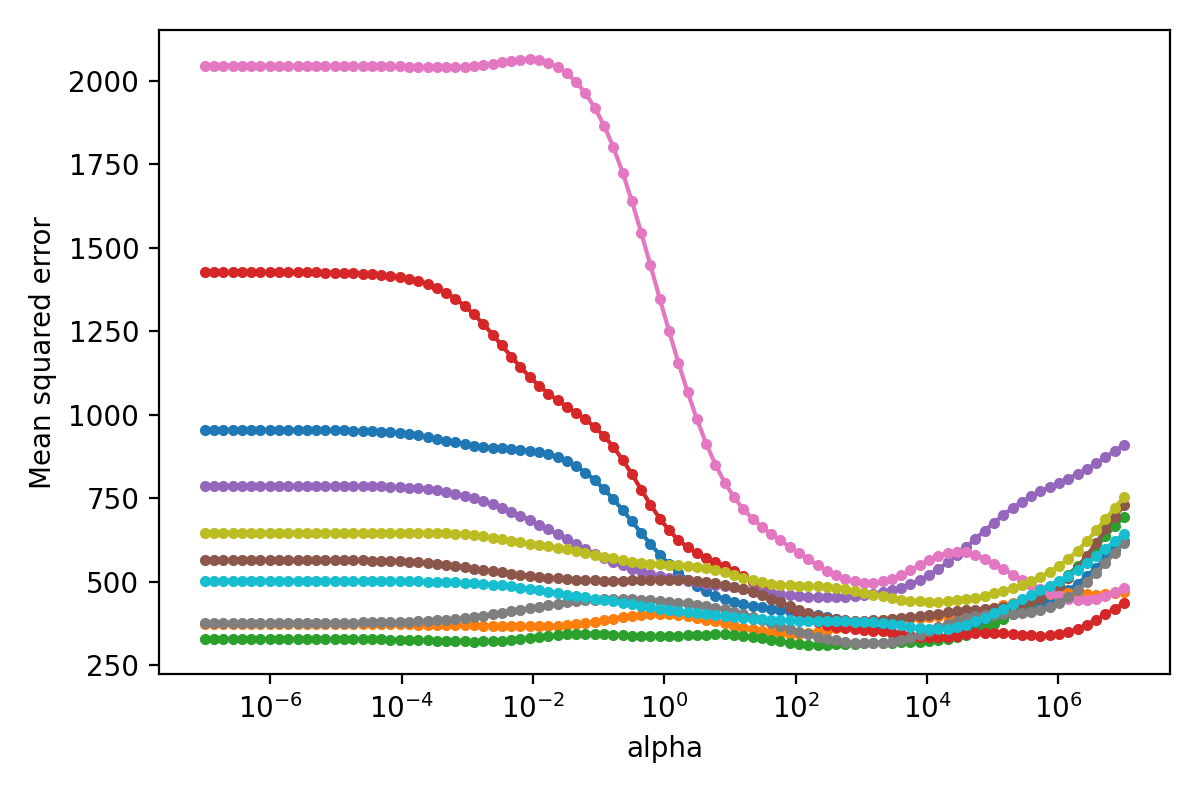

In [30]:
plt.figure(figsize=(6,4))
plt.plot(alphas, mse_cv.T, '.-')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('Mean squared error')
plt.tight_layout()

We also plot the average across folds:

<IPython.core.display.Javascript object>


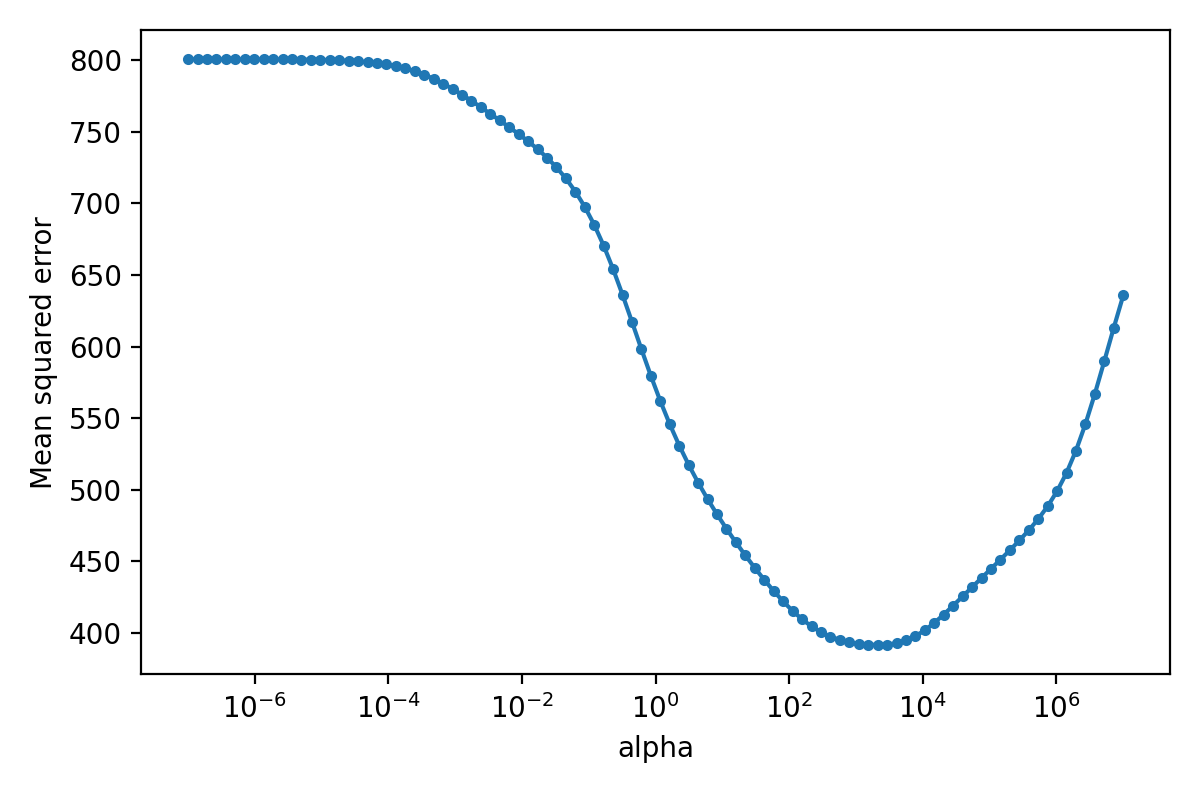

In [31]:
plt.figure(figsize=(6,4))
plt.plot(alphas, np.mean(mse_cv,axis=0), '.-')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('Mean squared error')
plt.tight_layout()

In [53]:
print('optimal alpha: ',alphas[np.argmin(np.mean(mse_cv, axis=0))])
print('MSE at optimal alpha: ',np.min(np.mean(mse_cv, axis=0)))

optimal alpha:  2009.2330025650458
MSE at optimal alpha:  391.6245700941729


What is the optimal $\alpha$? Is it similar to the one found on the test set? Do the cross-validation MSE and the test-set MSE match well or differ strongly?

- best alpha is a bit bigger (1000-10000)
- CV MSE is below 400, so a bit smaller

We will now run cross-validation on the full training data. This will take a moment, depending on the speed of your computer. Afterwards, we will again plot the mean CV curves for the full data set (blue) and the small data set (orange).

In [32]:
alphas = np.logspace(-7,10,100)
mse_cv = ridgeCV(X_train, y_train, n_folds=10, alphas=alphas)
mse_cv_full = ridgeCV(X_train_full, y_train_full, n_folds=10, alphas=alphas)

<IPython.core.display.Javascript object>


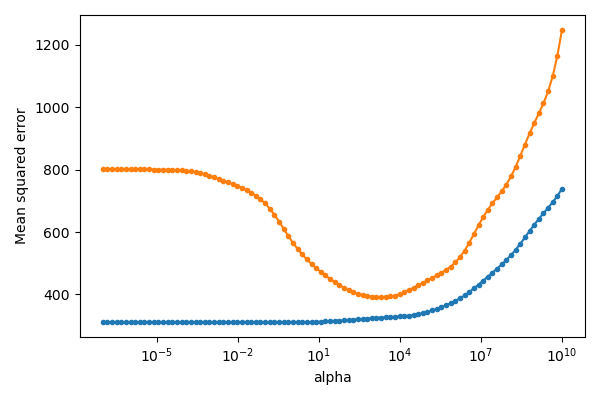

In [31]:
plt.figure(figsize=(6,4))
plt.plot(alphas, np.mean(mse_cv_full,axis=0), '.-')
plt.plot(alphas, np.mean(mse_cv,axis=0), '.-')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('Mean squared error')
plt.tight_layout()

We determine the (very subtle) minimum of the blue curve and zoom in around it to be able to see it:

<IPython.core.display.Javascript object>


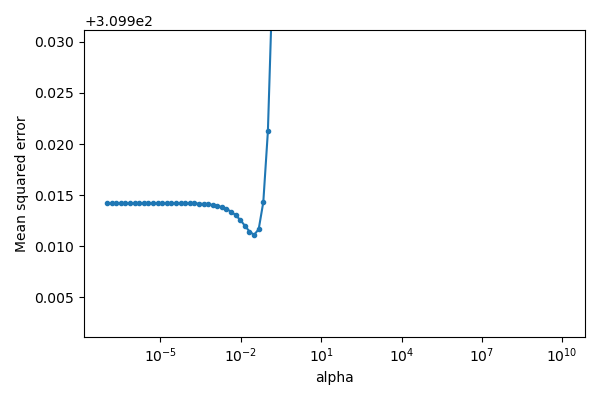

In [32]:
plt.figure(figsize=(6,4))
plt.plot(alphas, np.mean(mse_cv_full,axis=0), '.-')
plt.xscale('log')
minValue = np.min(np.mean(mse_cv_full,axis=0))
plt.ylim([minValue-.01, minValue+.02])
plt.xlabel('alpha')
plt.ylabel('Mean squared error')
plt.tight_layout()

Why does the CV curve on the full data set look so different? What is the optimal value of $\alpha$ and why is it so much smaller than on the small training set?

- No overfitting because of many datapoints, so regularization has no effect
- Optimal value of alpha is much smaller so the the ridge penalty is close to 0

# OBSOLETE

To demonstrate how the model overfits on the smaller dataset, we plot training and test error together as a function of alpha, first for the small and then for the full dataset.

In [33]:
def ridge_regression_sklearn2(X_test, X_train, y_train,alpha):

    regr = linear_model.Ridge(alpha)
    regr.fit(X_train, y_train)
    y_pred = regr.predict(X_test)
    y_pred_train = regr.predict(X_train)
    weights = np.squeeze(regr.coef_)
    return weights, y_pred, y_pred_train

<IPython.core.display.Javascript object>


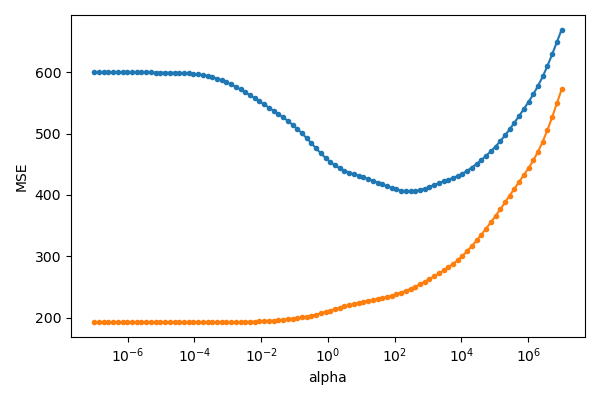

In [34]:
alphas = np.logspace(-7,7,100)
MSEs=[]
MSEs_train=[]

for i in range(len(alphas)):
    weights, y_pred, y_pred_train = ridge_regression_sklearn2(X_test, X_train, y_train, alphas[i])
    MSEs.append(mean_squared_error(y_pred,y_test))
    MSEs_train.append(mean_squared_error(y_pred_train,y_train))
    
plt.figure(figsize=(6,4))
plt.plot(alphas, MSEs, '.-')
plt.plot(alphas, MSEs_train, '.-')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.tight_layout()


<IPython.core.display.Javascript object>


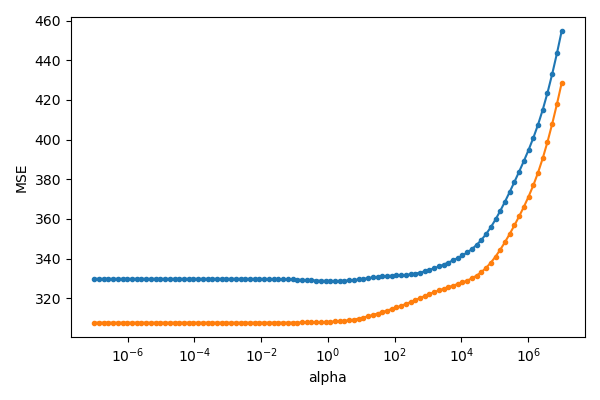

In [35]:
alphas = np.logspace(-7,7,100)
MSEs=[]
MSEs_train=[]

for i in range(len(alphas)):
    weights, y_pred, y_pred_train = ridge_regression_sklearn2(X_test, X_train_full, y_train_full, alphas[i])
    MSEs.append(mean_squared_error(y_pred,y_test))
    MSEs_train.append(mean_squared_error(y_pred_train,y_train_full))
    
plt.figure(figsize=(6,4))
plt.plot(alphas, MSEs, '.-')
plt.plot(alphas, MSEs_train, '.-')
plt.xscale('log')
plt.xlabel('alpha')
plt.ylabel('MSE')
plt.tight_layout()